# Inferring priors for causal learning

Researchers studying causal learning most commonly examine how people learn causal relationships from observing covarations among events. This has borne a lot of fruit and touched on some deep philosophical issues about the nature of causality (e.g., it’s all in our heads!). However, little of the causal knowledge that most people actually possess is achieved in this way. Instead, most of our causal knowledge comes from what others tell us about the world. Of course, people rarely convey causal information like, “the causal power of aspirin to reduce headaches is .25.” Instead, we communicate more vague information, like “aspirin helps with headaches.” Moreover, we communicate and possess even more abstract understandings of how different types of causal entities interact and how different different causal mechanisms operate, that let us draw inferences about specific causal relationships from generalities. How do these forms of knowledge interact in our causal inferences?

This is a preliminary exploration for a project I’m considering that would examine how mechanistic understandings or explanations might shape people’s priors about causal relationships. The idea is that our abstract understanding of causal mechanisms could be expressed as different priors about the possible strengths of causal relationships. Given different cover stories suggesting different potential mechanisms, we should expect different kinds of observations. 

With that, the idea is to use numpyro to combine __bayesian cognitive modeling and bayesian data analysis__ to infer causal learner’s domain-specific priors based on their responses in a causal learning task. This would begin to suggest ways in which we might connect these two forms of causal knowledge.

This notebook is a preliminary proof-of-concept test to see whether this kind of approach could work. In this notebook, I’ll simulate some causal power estimates with a model of a causal learner. I’ll simulate data for two different sets of contingency data and with priors for two different contexts. Then, I’ll do bayesian data analysis over the bayesian cognitive model and we’ll see how well we can recover the original parameters.

In [1]:
import numpyro
numpyro.enable_x64()

import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import  MCMC, SA, Predictive, NUTS, DiscreteHMCGibbs, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation, AutoMultivariateNormal

import numpy as np
import jax.numpy as jnp
import jax
from jax.random import PRNGKey
from jax.scipy.special import expit, logit

from tensorflow_probability import distributions as tfdist

import seaborn as sns
import functools
import pandas as pd

def make_random(fn):
    key = jax.random.PRNGKey(np.random.randint(0, 1e6))
    return handlers.seed(fn, rng_seed=key)

def repeat_func(n, fn, *args):
    return jnp.stack([fn(*args) for _ in range(0,n)])

def laplace_approx(model, *args):
    guide = AutoLaplaceApproximation(model)
    optimizer = numpyro.optim.Minimize()
    svi = SVI(model, guide, optimizer, Trace_ELBO())
    init_state = svi.init(PRNGKey(0), *args)
    optimal_state, loss = svi.update(init_state, *args)
    return guide.get_posterior(svi.get_params(optimal_state))

def MVNorm_approx(model, *args):
    guide = AutoMultivariateNormal(model)
    optimizer = numpyro.optim.Adagrad(step_size=.1)
    svi = SVI(model, guide, optimizer, Trace_ELBO())
    result = svi.run(PRNGKey(0), 3000, *args, progress_bar=False)
    transform = guide.get_transform(result.params)
    raw_posterior = guide.get_posterior(result.params)
    
    return raw_posterior

# Simulate Responses

As an example, here I sample the posterior over expected occurrences of some effect E, given cause C and background causes B, after learning the contingency data where the effect occurs 2/10 times when the cause is not present, and 9/10 times when the cause is present.

I'll use MCMC to sample from the causal learner's posterior, first with a uniform prior to see the "true" (unbiased) causal powers.

In [2]:
contingencies = {
    "C":jnp.array([0,1]), 
    "effect":jnp.array([2,9]), 
    "N":jnp.array([10,10])
}

def powerPCprob(c, wc, wb):
    # c: 0 or 1    # wc: [0,1]    # wB: [0,1]
    return c*wc + wb - c*wc*wb

prior_uniform = (1,1)
prior_weak = (2,5)
prior_strong = (5,2)

def observerModel(prior_tuple, contingencies):
    # priors = distribution object
    # contingencies = dict
    cause = contingencies["C"]
    effect = contingencies["effect"]
    N = contingencies["N"]

    wc = numpyro.sample("wc", dist.Beta(*prior_tuple))
    wb = numpyro.sample("wb", dist.Beta(1,1))
    prob = powerPCprob(cause, wc, wb)
    with numpyro.plate("obs", len(cause)):
        numpyro.sample("cmodel", dist.Binomial(N, prob), obs=effect)    


In [3]:
kernel = NUTS(observerModel, target_accept_prob=.80)
posterior = MCMC(kernel, 500, 500, num_chains=1)

posterior.run(PRNGKey(0), prior_uniform, contingencies)

sample: 100%|██████████| 1000/1000 [00:02<00:00, 411.34it/s, 3 steps of size 9.14e-01. acc. prob=0.86]


In [4]:
posterior.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        wb      0.28      0.13      0.26      0.06      0.47    426.62      1.00
        wc      0.76      0.15      0.79      0.55      1.00    327.98      1.00

Number of divergences: 0


And we get the same results by laplace approximation for this simple model (modulo sampling error).

In [5]:
expit(laplace_approx(observerModel, prior_uniform, contingencies).loc)

DeviceArray([0.26596262, 0.78139321], dtype=float64)

I'll fit the model twice for strong and weak priors on $w_c$ and use the posterior to simulate participants responses.

For weak priors, I'll assume $w_c \sim beta(2,5)$ and for strong priors I'll assume  $w_c \sim beta(5,2)$.

In [6]:
posterior_weak = MCMC(NUTS(observerModel, target_accept_prob=.80), 500, 500, num_chains=1)
posterior_weak.run(PRNGKey(0), prior_weak, contingencies)

posterior_weak.print_summary()

sample: 100%|██████████| 1000/1000 [00:02<00:00, 394.68it/s, 3 steps of size 7.23e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        wb      0.34      0.14      0.34      0.13      0.57    323.86      1.00
        wc      0.51      0.17      0.50      0.24      0.78    154.56      1.00

Number of divergences: 0


In [7]:
posterior_strong = MCMC(NUTS(observerModel, target_accept_prob=.80), 500, 500, num_chains=1)
posterior_strong.run(PRNGKey(0), prior_strong, contingencies)

posterior_strong.print_summary()

sample: 100%|██████████| 1000/1000 [00:02<00:00, 392.28it/s, 3 steps of size 7.94e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        wb      0.27      0.12      0.26      0.08      0.44    370.87      1.00
        wc      0.79      0.11      0.80      0.64      0.96    324.55      1.00

Number of divergences: 0


Below are some plots of the posteriors on $w_c$ for strong and weak priors.

<AxesSubplot:ylabel='Count'>

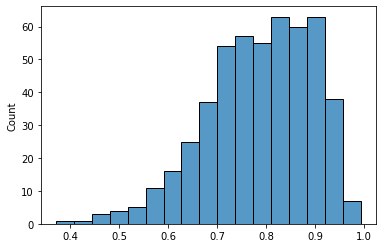

In [8]:
c_resp_weak = posterior_weak.get_samples()["wc"]
b_resp_weak = posterior_weak.get_samples()["wb"]

c_resp_strong = posterior_strong.get_samples()["wc"]
b_resp_strong = posterior_strong.get_samples()["wb"]

sns.histplot(c_resp_strong)

<AxesSubplot:ylabel='Count'>

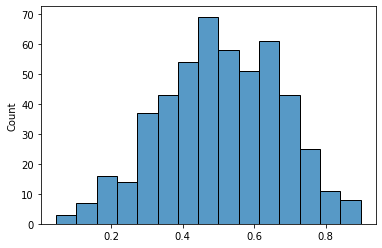

In [9]:
sns.histplot(c_resp_weak)

# Inferring priors from responses

Now we’ll do bayesian data analysis over our bayesian cognitive model, and see if we can recover the parameters of the prior distributions.

In [20]:
data_dict = {"c_resp": c_resp_weak[-100:], "b_resp": b_resp_weak[-100:]}

def model(responses, contingencies):
    c_resp = responses["c_resp"]
    b_resp = responses["b_resp"]
    
    a = numpyro.sample("a", dist.HalfCauchy(10))
    b = numpyro.sample("b", dist.HalfCauchy(10))
    
    with handlers.block():
        pred_powers = laplace_approx(observerModel, (a, b), contingencies)
    
    resps = jnp.stack([b_resp, c_resp], axis=-1)
    
    with numpyro.plate("data", c_resp.shape[0]):
        numpyro.sample("obs", pred_powers, obs=logit(resps))

In [21]:
# posterior = MCMC(NUTS(model), 1_000, 1_000, num_chains=1)
posterior = MCMC(SA(model), 20_000, 40_000, num_chains=1, progress_bar=False)
%time posterior.run(PRNGKey(0), data_dict, contingencies)

CPU times: user 23.9 s, sys: 99.9 ms, total: 24 s
Wall time: 23.9 s


In [22]:
posterior.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.21      0.42      1.19      0.48      1.88    671.60      1.00
         b      4.90      0.56      4.89      3.94      5.76    681.96      1.00

Number of divergences: 0


# Voila!

Seems like this is sort of approximately working! I may need to simulate some better/more diagnostic data. And the effective samples are pretty low, but no divergent transitions. Some notes:

* Works with my `MVNorm_approx()` and `NUTS` MCMC
* Also works with `laplace_approx()` and `SA` MCMC, but gives more biased results (but it's super fast!)
* Runs with `laplace_approx()` and `NUTS(..., forward_mode_differentiation=True)` but gives totally messed up results.